Variables: ['__header__', '__version__', '__globals__', 'unitdata', 'samples', 'spkmat', 'startOrder', 'start']
unitdata fields: ['units']
units: shape (52,)


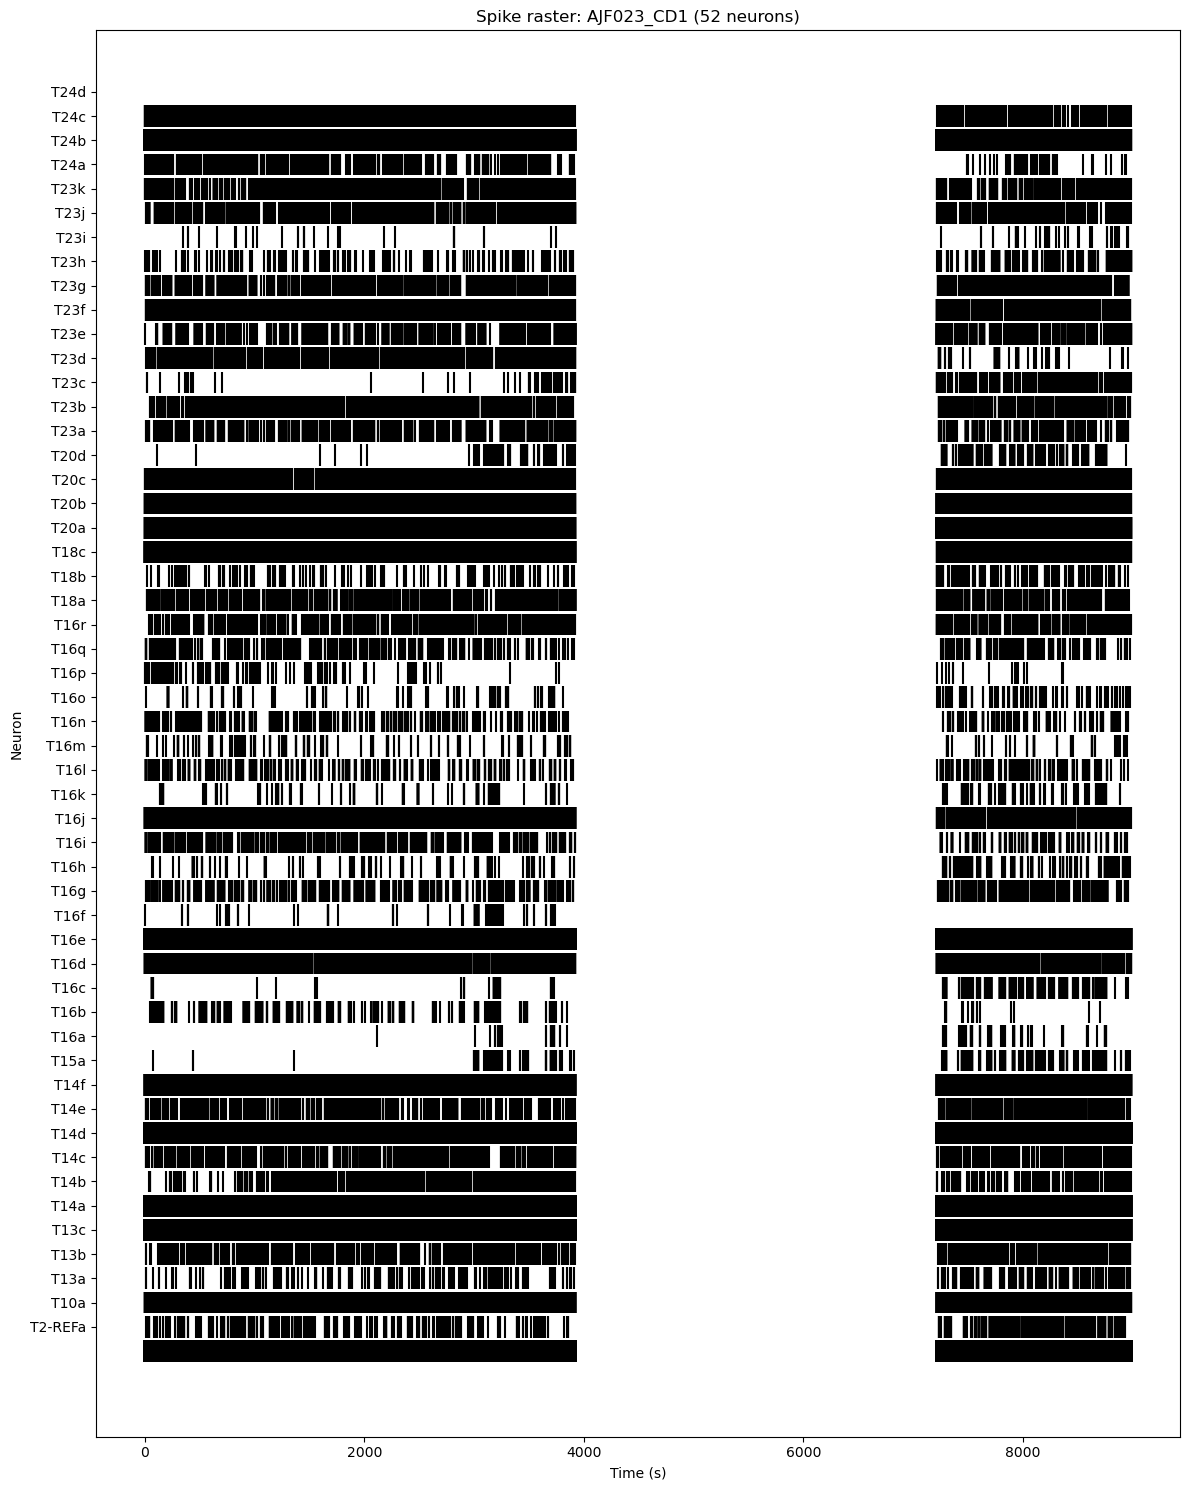

In [1]:
import scipy.io
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

# test load one file and plot its spike raster
file_path = '/Users/bytedance/Documents/PHD/datasets/2016_Eichenbaum/AJF023/CD1/AJF023CD1SpksEvsSimple.mat'

mat = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)

print("Variables:", list(mat.keys()))

unitdata = mat['unitdata']

print("unitdata fields:", unitdata._fieldnames)

for field in unitdata._fieldnames:
    data = getattr(unitdata, field)
    print(f"{field}: shape {getattr(data, 'shape', 'scalar')}")

# Extract neurons and create spike raster plot
units = unitdata.units
neurons = {}
neuron_names = []

for i in range(len(units)):
    unit = units[i]
    if hasattr(unit, 'ts'):
        spiketimes = unit.ts.flatten()  # spike times in seconds
        
        # Get neuron name - use actual name from mat file if available
        if hasattr(unit, 'name') and unit.name:
            name = unit.name if isinstance(unit.name, str) else str(unit.name)
        else:
            # Fallback to generated name if no name in mat file
            name = f"cell{i+1}"
        
        neurons[name] = spiketimes
        neuron_names.append(name)

# Create spike raster plot
if len(neurons) > 0:
    plt.figure(figsize=(12, max(len(neurons)*0.25 + 2, 4)))
    plt.eventplot([spiketimes for spiketimes in neurons.values()], 
                  orientation='horizontal', 
                  colors='black', 
                  lineoffsets=1,
                  linelengths=0.9)
    plt.yticks(range(1, len(neurons)+1), neuron_names)
    plt.xlabel("Time (s)")
    plt.ylabel("Neuron")
    plt.title(f"Spike raster: AJF023_CD1 ({len(neurons)} neurons)")
    plt.tight_layout()
    plt.show()
else:
    print("No neurons found to plot")
    

In [4]:
import glob
import numpy as np
from pathlib import Path
import scipy.io
import os
import gc

# Find all SpksEvsSimple.mat files
base_dir = '/Users/bytedance/Documents/PHD/datasets/2016_Eichenbaum'
mat_files = glob.glob(os.path.join(base_dir, '**', '*SpksEvsSimple.mat'), recursive=True)
mat_files.sort()

print(f"Found {len(mat_files)} session files\n")

# Statistics storage
session_stats = []

# Process each session - rolling memory management
for file_path in mat_files:
    mat = None
    units = None
    try:
        # Load one file at a time
        mat = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
        
        if 'unitdata' not in mat:
            print(f"Skipping {file_path}: no unitdata")
            del mat
            gc.collect()
            continue
            
        units = mat['unitdata'].units
        
        # Extract session info from path
        path_parts = Path(file_path).parts
        animal_id = path_parts[-3] if len(path_parts) >= 3 else "unknown"
        session_id = path_parts[-2] if len(path_parts) >= 2 else "unknown"
        session_name = f"{animal_id}_{session_id}"
        
        # Collect statistics for this session
        n_units = len(units)
        total_spikes = 0
        firing_rates = []
        session_duration = 0
        
        for unit in units:
            if hasattr(unit, 'ts'):
                spiketimes = unit.ts.flatten()
                n_spikes = len(spiketimes)
                total_spikes += n_spikes
                
                if n_spikes > 0:
                    duration = spiketimes.max() - spiketimes.min() if len(spiketimes) > 1 else 0
                    session_duration = max(session_duration, duration)
                    firing_rate = n_spikes / duration if duration > 0 else 0
                    firing_rates.append(firing_rate)
                # Clear spiketimes from memory immediately after use
                del spiketimes
        
        mean_fr = np.mean(firing_rates) if firing_rates else 0
        median_fr = np.median(firing_rates) if firing_rates else 0
        
        stats = {
            'session': session_name,
            'animal': animal_id,
            'session_id': session_id,
            'file_path': file_path,
            'n_units': n_units,
            'total_spikes': total_spikes,
            'mean_firing_rate': mean_fr,
            'median_firing_rate': median_fr,
            'session_duration': session_duration,
            'n_active_units': len(firing_rates)
        }
        session_stats.append(stats)
        
        # Clear intermediate variables
        del firing_rates
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    finally:
        # Explicitly release memory after processing each file
        if units is not None:
            del units
        if mat is not None:
            del mat
        # Force garbage collection to free memory
        gc.collect()

# Convert to structured format for easier analysis
print("="*80)
print("SESSION STATISTICS SUMMARY")
print("="*80)

# Overall statistics
print(f"\nTotal sessions: {len(session_stats)}")
print(f"Total units across all sessions: {sum(s['n_units'] for s in session_stats)}")
print(f"Total spikes across all sessions: {sum(s['total_spikes'] for s in session_stats):,}")

# Per-animal statistics
animals = {}
for stats in session_stats:
    animal = stats['animal']
    if animal not in animals:
        animals[animal] = {'sessions': 0, 'units': 0, 'spikes': 0}
    animals[animal]['sessions'] += 1
    animals[animal]['units'] += stats['n_units']
    animals[animal]['spikes'] += stats['total_spikes']

print(f"\nNumber of animals: {len(animals)}")
print("\nPer-animal summary:")
for animal, data in sorted(animals.items()):
    print(f"  {animal}: {data['sessions']} sessions, {data['units']} units, {data['spikes']:,} spikes")

# Unit count statistics
unit_counts = [s['n_units'] for s in session_stats]
print(f"\nUnits per session:")
print(f"  Mean: {np.mean(unit_counts):.1f}")
print(f"  Median: {np.median(unit_counts):.1f}")
print(f"  Min: {np.min(unit_counts)}")
print(f"  Max: {np.max(unit_counts)}")
print(f"  Std: {np.std(unit_counts):.1f}")

# Firing rate statistics
firing_rates_all = [s['mean_firing_rate'] for s in session_stats if s['mean_firing_rate'] > 0]
if firing_rates_all:
    print(f"\nMean firing rate per session (Hz):")
    print(f"  Mean: {np.mean(firing_rates_all):.2f}")
    print(f"  Median: {np.median(firing_rates_all):.2f}")
    print(f"  Min: {np.min(firing_rates_all):.2f}")
    print(f"  Max: {np.max(firing_rates_all):.2f}")

# Session duration statistics
durations = [s['session_duration'] for s in session_stats if s['session_duration'] > 0]
if durations:
    print(f"\nSession duration (seconds):")
    print(f"  Mean: {np.mean(durations):.1f}")
    print(f"  Median: {np.median(durations):.1f}")
    print(f"  Min: {np.min(durations):.1f}")
    print(f"  Max: {np.max(durations):.1f}")

# Active units statistics
active_units = [s['n_active_units'] for s in session_stats]
print(f"\nActive units per session (units with spikes):")
print(f"  Mean: {np.mean(active_units):.1f}")
print(f"  Median: {np.median(active_units):.1f}")
print(f"  Min: {np.min(active_units)}")
print(f"  Max: {np.max(active_units)}")

print("\n" + "="*80)
print("First 10 sessions detail:")
print("="*80)
for i, stats in enumerate(session_stats[:10]):
    print(f"{i+1}. {stats['session']}: {stats['n_units']} units, "
          f"{stats['total_spikes']:,} spikes, "
          f"FR={stats['mean_firing_rate']:.2f} Hz, "
          f"duration={stats['session_duration']:.1f}s")


Found 51 session files

SESSION STATISTICS SUMMARY

Total sessions: 51
Total units across all sessions: 1757
Total spikes across all sessions: 19,610,623

Number of animals: 5

Per-animal summary:
  AJF016: 11 sessions, 132 units, 2,977,298 spikes
  AJF023: 11 sessions, 432 units, 6,998,199 spikes
  AJF025: 9 sessions, 315 units, 4,751,167 spikes
  AJF027: 10 sessions, 421 units, 2,521,994 spikes
  AJF033: 10 sessions, 457 units, 2,361,965 spikes

Units per session:
  Mean: 34.5
  Median: 35.0
  Min: 6
  Max: 70
  Std: 16.4

Mean firing rate per session (Hz):
  Mean: 2.43
  Median: 2.16
  Min: 0.37
  Max: 6.75

Session duration (seconds):
  Mean: 6001.7
  Median: 5203.7
  Min: 2781.7
  Max: 13095.3

Active units per session (units with spikes):
  Mean: 34.5
  Median: 35.0
  Min: 6
  Max: 70

First 10 sessions detail:
1. AJF016_CD1: 17 units, 418,796 spikes, FR=4.12 Hz, duration=5996.0s
2. AJF016_CD2: 13 units, 209,784 spikes, FR=3.07 Hz, duration=5292.8s
3. AJF016_CD3: 11 units, 362,60

In [5]:
# Save all sessions to pkl files with correct directory structure and spike raster PNGs
import matplotlib.pyplot as plt

# Use relative path from workspace, or absolute if /data exists
if os.path.exists('/data'):
    output_base_dir = '/data/eichenbaum2016'
else:
    # Relative to workspace
    output_base_dir = 'data/eichenbaum2016'

# Process each session and save
for file_path in mat_files:
    mat = None
    units = None
    fig = None
    try:
        # Load one file at a time
        mat = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
        
        if 'unitdata' not in mat:
            print(f"Skipping {file_path}: no unitdata")
            del mat
            gc.collect()
            continue
            
        units = mat['unitdata'].units
        
        # Extract session info from path
        path_parts = Path(file_path).parts
        animal_id = path_parts[-3] if len(path_parts) >= 3 else "unknown"
        session_id = path_parts[-2] if len(path_parts) >= 2 else "unknown"
        
        # Create output directory structure
        output_dir = Path(output_base_dir) / animal_id / session_id
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Create output filenames (using session name)
        pkl_filename = f"{animal_id}_{session_id}.pkl"
        png_filename = f"{animal_id}_{session_id}_spike_raster.png"
        pkl_path = output_dir / pkl_filename
        png_path = output_dir / png_filename
        
        # Extract neurons with their actual names
        neurons = {}
        for i in range(len(units)):
            unit = units[i]
            if hasattr(unit, 'ts'):
                spiketimes = unit.ts.flatten()  # spike times in seconds
                
                # Get neuron name - use actual name from mat file if available
                if hasattr(unit, 'name') and unit.name:
                    name = unit.name if isinstance(unit.name, str) else str(unit.name)
                else:
                    # Fallback to generated name if no name in mat file
                    name = f"{animal_id}_{session_id}_cell{i+1}"
                
                neurons[name] = spiketimes
                # Note: keep spiketimes in memory for plotting, will clear after
        
        # Save to pkl file
        with open(pkl_path, 'wb') as f:
            pickle.dump(neurons, f)
        
        # Create and save spike raster plot
        if len(neurons) > 0:
            fig = plt.figure(figsize=(12, max(len(neurons)*0.25 + 2, 4)))
            plt.eventplot([spiketimes for spiketimes in neurons.values()], 
                          orientation='horizontal', 
                          colors='black', 
                          lineoffsets=1,
                          linelengths=0.9)
            plt.yticks(range(1, len(neurons)+1), list(neurons.keys()))
            plt.xlabel("Time (s)")
            plt.ylabel("Neuron")
            plt.title(f"Spike raster: {animal_id}_{session_id} ({len(neurons)} neurons)")
            plt.tight_layout()
            plt.savefig(png_path, dpi=150, bbox_inches='tight')
            plt.close(fig)  # Close figure to free memory
            fig = None
        
        print(f"Saved {len(neurons)} neurons to {pkl_path} and raster to {png_path}")
        
        # Clear intermediate variables
        del neurons
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    finally:
        # Explicitly release memory after processing each file
        if fig is not None:
            plt.close(fig)
        if units is not None:
            del units
        if mat is not None:
            del mat
        # Force garbage collection to free memory
        gc.collect()

print(f"\nCompleted saving all sessions to {output_base_dir}")


Saved 17 neurons to data/eichenbaum2016/AJF016/CD1/AJF016_CD1.pkl and raster to data/eichenbaum2016/AJF016/CD1/AJF016_CD1_spike_raster.png
Saved 13 neurons to data/eichenbaum2016/AJF016/CD2/AJF016_CD2.pkl and raster to data/eichenbaum2016/AJF016/CD2/AJF016_CD2_spike_raster.png
Saved 11 neurons to data/eichenbaum2016/AJF016/CD3/AJF016_CD3.pkl and raster to data/eichenbaum2016/AJF016/CD3/AJF016_CD3_spike_raster.png
Saved 10 neurons to data/eichenbaum2016/AJF016/CD3EF1/AJF016_CD3EF1.pkl and raster to data/eichenbaum2016/AJF016/CD3EF1/AJF016_CD3EF1_spike_raster.png
Saved 20 neurons to data/eichenbaum2016/AJF016/CDEF1/AJF016_CDEF1.pkl and raster to data/eichenbaum2016/AJF016/CDEF1/AJF016_CDEF1_spike_raster.png
Saved 13 neurons to data/eichenbaum2016/AJF016/CDEF2/AJF016_CDEF2.pkl and raster to data/eichenbaum2016/AJF016/CDEF2/AJF016_CDEF2_spike_raster.png
Saved 6 neurons to data/eichenbaum2016/AJF016/CDEF3/AJF016_CDEF3.pkl and raster to data/eichenbaum2016/AJF016/CDEF3/AJF016_CDEF3_spike_ras